In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

Image format: JPEG; shape: (1496, 1729); color scheme: RGB


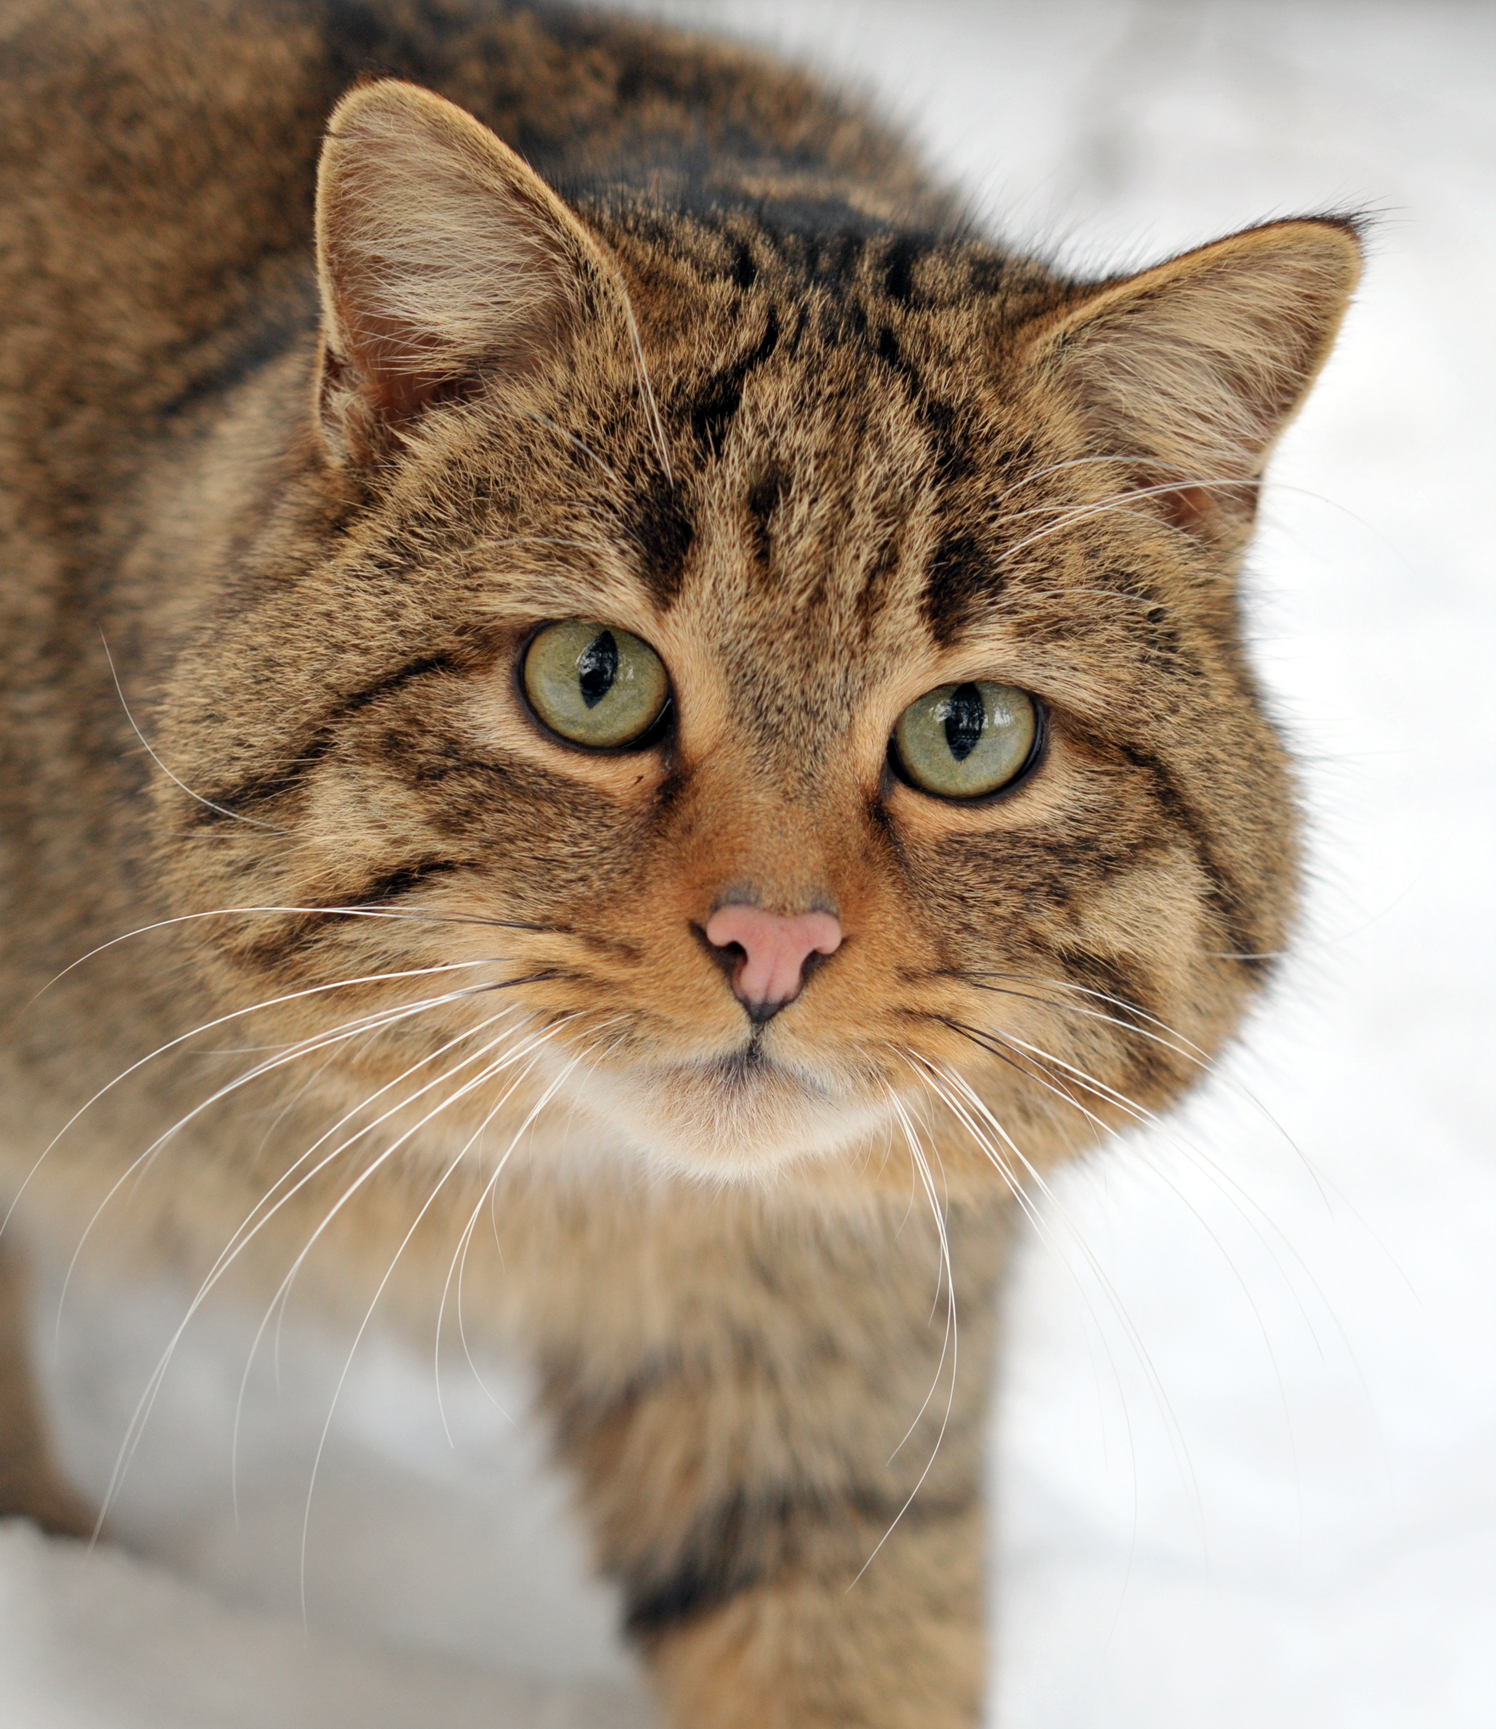

In [2]:
from PIL import Image

img = Image.open("cat.jpg")
print(f"Image format: {img.format}; shape: {img.size}; color scheme: {img.mode}")
img

Image matrix shape: (1729, 1496, 3)


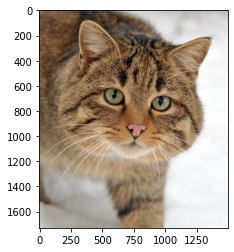

In [3]:
img_matrix = np.array(img)

print(f"Image matrix shape: {img_matrix.shape}")

plt.imshow(img_matrix)
plt.show()

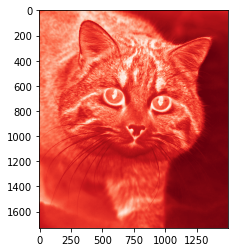

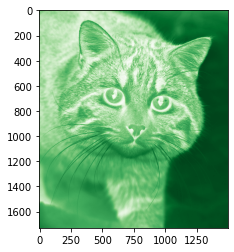

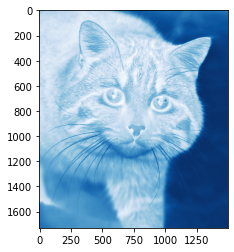

In [4]:
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

In [5]:
import torch
from torch.nn.functional import conv2d

In [6]:
img_tensor = torch.tensor([img_matrix], dtype=torch.float)
img_tensor.size()

torch.Size([1, 1729, 1496, 3])

In [7]:
img_tensor = img_tensor.permute(0, 3, 1, 2)
img_tensor.size()

torch.Size([1, 3, 1729, 1496])

In [8]:
sobel_hor = [[-1, -2, -1], 
             [ 0,  0,  0], 
             [ 1,  2,  1]]

kernel  = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()

torch.Size([1, 3, 3, 3])

In [9]:
img_conv_hor = conv2d(img_tensor, kernel)
img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size() 

torch.Size([1, 1727, 1494, 1])

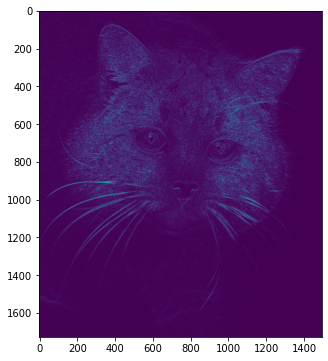

In [10]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))
plt.show()

In [11]:
sobel_ver = [[-1, 0, 1], 
             [-2, 0, 2], 
             [-1, 0, 1]]

kernel  = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()

torch.Size([1, 3, 3, 3])

In [12]:
img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size()

torch.Size([1, 1727, 1494, 1])

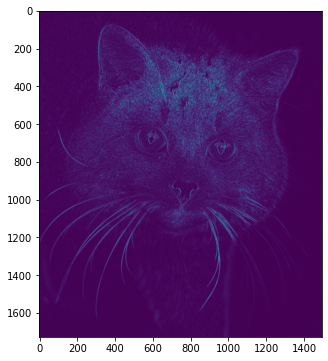

In [13]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

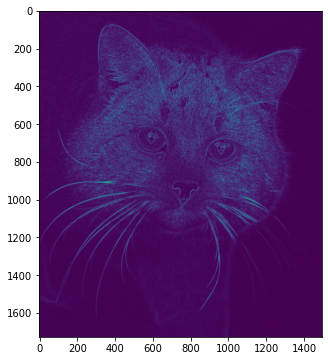

In [14]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(img_conv[0, :, :, 0])
plt.show()

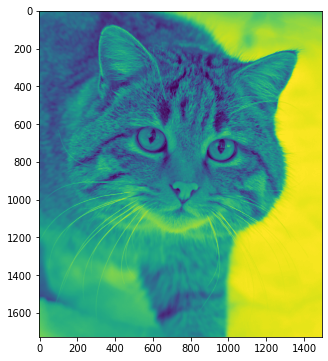

In [15]:
kernel = torch.rand((1, 3, 3, 3), dtype=torch.float)

img_conv_ver = conv2d(img_tensor, kernel)
img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

In [16]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn

In [17]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/", 
    train=True, 
    download=True, 
    transform=transform
) 
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False, 
    download=True,
    transform=transform
)


train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



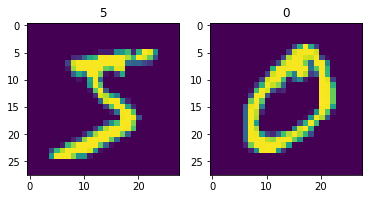

In [18]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [19]:
model = nn.Sequential(
    nn.Flatten(),             
    nn.Linear(28 * 28, 128), 
    nn.ReLU(),                
    nn.Linear(128, 10),      
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [20]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):
      
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

   
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

           
            print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

In [21]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.32161518931388855, accuracy: 0.9095


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.23312810063362122, accuracy: 0.9316


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.18911930918693542, accuracy: 0.944


In [22]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4), 
    nn.Flatten(),                
    nn.Linear(6*6*10, 128),       
    nn.ReLU(),                   
    nn.Linear(128, 10),           
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [23]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.22754734754562378, accuracy: 0.9374


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.10347689688205719, accuracy: 0.9689


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.08734218031167984, accuracy: 0.9741
